# 🔥 GRU Model Training: Emotion Classification

This notebook trains a GRU (Gated Recurrent Unit) model on preprocessed emotion data using **Word2Vec** pre-trained embeddings.

**Embedding Strategy:** Word2Vec (Google News, 300d) - captures local context patterns that complement GRU's fast sequential processing.


## 📚 Import Libraries


## 📦 Install Dependencies (Run on Colab)

In [1]:
# Check if running on Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# Install dependencies only on Colab
if IN_COLAB:
    print("Running on Google Colab - Installing dependencies...")
    %pip install -q gensim==4.4.0 h5py==3.15.1 keras==3.12.0 matplotlib==3.10.6 nltk==3.9.2 numpy==2.2.5 pandas==2.3.3 scikit-learn==1.7.2 scipy==1.15.3 seaborn==0.13.2 tensorflow==2.20.0 wordcloud==1.9.4
    print("Dependencies installed successfully!")
else:
    print("Running locally - Using local dependencies")

Running locally - Using local dependencies


## 🖥️ GPU Configuration Check


In [2]:
# Check GPU availability
import tensorflow as tf

print("=" * 60)
print("🔍 CHECKING GPU AVAILABILITY")
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

# Get GPU devices
gpus = tf.config.list_physical_devices('GPU')
print(f"\nNumber of GPUs Available: {len(gpus)}")

if len(gpus) > 0:
    print("\n✅ GPU IS AVAILABLE - Training will use GPU acceleration!")
    for i, gpu in enumerate(gpus):
        print(f"\n   GPU {i}: {gpu.name}")
        # Get memory info
        try:
            gpu_details = tf.config.experimental.get_device_details(gpu)
            if gpu_details:
                print(f"   Device: {gpu_details.get('device_name', 'Unknown')}")
                print(f"   Compute Capability: {gpu_details.get('compute_capability', 'Unknown')}")
        except:
            pass
    print("\n   🚀 Expected speedup: 3-5x faster than CPU!")
else:
    print("\n⚠️  NO GPU DETECTED - Training will use CPU only")
    print("   Note: CPU training is slower but will still work")

print("=" * 60)


2025-11-26 11:31:44.881847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


🔍 CHECKING GPU AVAILABILITY
TensorFlow version: 2.20.0
Built with CUDA: True

Number of GPUs Available: 1

✅ GPU IS AVAILABLE - Training will use GPU acceleration!

   GPU 0: /physical_device:GPU:0
   Device: Quadro T2000
   Compute Capability: (7, 5)

   🚀 Expected speedup: 3-5x faster than CPU!


In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


---

**📝 Important Note on GPU Usage:**

TensorFlow **automatically detects and uses your GPU** for all operations when available. You don't need to modify any code! 

- If GPU was detected above ✅, all training will run on GPU automatically
- The `model.fit()`, `model.predict()`, and all Keras layers run on GPU by default
- No special code or device placement needed - it just works!

Monitor GPU usage in terminal: `watch -n 1 nvidia-smi`

---


## 📂 Load Preprocessed Data


In [4]:
# Load preprocessed training and validation data
train_df = pd.read_pickle('./data/train_preprocessed.pkl')
val_df = pd.read_pickle('./data/validation_preprocessed.pkl')

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())


Training data shape: (15999, 2)
Validation data shape: (2000, 2)

Columns: ['Text', 'Label']

First few rows:
                                                Text  Label
0                              didnt feel humiliated      0
1  go feeling hopeless damned hopeful around some...      0
2          im grabbing minute post feel greedy wrong      3
3  ever feeling nostalgic fireplace know still pr...      2
4                                    feeling grouchy      3


In [5]:
train_df.head(10)

,Text,Label
0,didnt feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,im grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,2
4,feeling grouchy,3
5,ive feeling little burdened lately wasnt sure,0
6,ive taking milligrams times recommended amount...,5
7,feel confused life teenager jaded year old man,4
8,petronas years feel petronas performed well ma...,1
9,feel romantic,2


## 📊 Prepare Data

Split the data into features (X) and labels (y).


In [6]:
#  Prepare X and y
X_train = train_df['Text']
y_train = train_df['Label']
X_val = val_df['Text']
y_val = val_df['Label']

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"\nLabel distribution in training set:")
print(y_train.value_counts().sort_index())


Training samples: 15999
Validation samples: 2000

Label distribution in training set:
Label
0    4666
1    5361
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


## 🔠 Tokenization

Convert text to sequences of integers.


In [7]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Find maximum sequence length
maxlen = max(len(tokens) for tokens in X_train_sequences)
print(f"Maximum sequence length: {maxlen}")

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=maxlen, padding='post')

print(f"\nX_train_padded shape: {X_train_padded.shape}")
print(f"X_val_padded shape: {X_val_padded.shape}")

# Calculate input size for embedding layer
input_size = np.max(X_train_padded) + 1
print(f"Vocabulary size (input_size): {input_size}")


Maximum sequence length: 35

X_train_padded shape: (15999, 35)
X_val_padded shape: (2000, 35)
Vocabulary size (input_size): 15064


## 🔤 Prepare Word2Vec Embeddings

Using pre-trained **Word2Vec** embeddings for the GRU model. Word2Vec captures local context patterns, which complements GRU's fast sequential processing.


In [8]:
# Download and prepare Word2Vec embeddings
import gensim.downloader as api

print("📥 Downloading Word2Vec pre-trained embeddings (Google News 300d)...")
print("This may take a few minutes on first run...")

# Download pre-trained Word2Vec model (Google News, 300 dimensions)
word2vec_model = api.load('word2vec-google-news-300')

print("✅ Word2Vec embeddings loaded successfully!")

# Embedding dimension
embedding_dim = 300

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill embedding matrix with Word2Vec vectors
hits = 0
misses = 0

for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
        hits += 1
    except KeyError:
        # Word not in Word2Vec vocabulary, leave as zeros
        misses += 1

print(f"\n📊 Embedding Matrix Statistics:")
print(f"   Vocabulary size: {vocab_size}")
print(f"   Embedding dimension: {embedding_dim}")
print(f"   Words found in Word2Vec: {hits}")
print(f"   Words not found (using zeros): {misses}")
print(f"   Coverage: {100 * hits / (hits + misses):.2f}%")


📥 Downloading Word2Vec pre-trained embeddings (Google News 300d)...
This may take a few minutes on first run...
✅ Word2Vec embeddings loaded successfully!

📊 Embedding Matrix Statistics:
   Vocabulary size: 15064
   Embedding dimension: 300
   Words found in Word2Vec: 13702
   Words not found (using zeros): 1361
   Coverage: 90.96%


## 🔬 Hyperparameter Tuning Experiments

Now let's systematically test different hyperparameters to understand their impact on model performance.


In [9]:
# Function to create and train a GRU model with custom hyperparameters
def train_gru_model(gru_units=128, dropout_rate=0.5, learning_rate=0.001, 
                     batch_size=32, dense_units=64, epochs=10, 
                     embedding_trainable=False, optimizer_name='adam'):
    """
    Train a GRU model with specified hyperparameters and return validation results.
    """
    # Build model
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=embedding_trainable
    ))
    model.add(Bidirectional(GRU(gru_units)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    
    # Compile with specified optimizer and learning rate
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = 'adam'
    
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(
        X_train_padded, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_padded, y_val),
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0  # Suppress output for cleaner results
    )
    
    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_padded, y_val, verbose=0)
    
    return {
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'best_epoch': len(history.history['val_accuracy']),
        'history': history.history
    }

print("✅ Helper function defined")


✅ Helper function defined


### 🔍 Experiment 1: Learning Rate

Test different learning rates to find the optimal value.


Testing different learning rates...
Testing learning rate: 0.0001


I0000 00:00:1764149548.490568   17541 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2604 MB memory:  -> device: 0, name: Quadro T2000, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-11-26 11:32:32.717485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


  Val Accuracy: 0.7830, Val Loss: 0.5942

Testing learning rate: 0.0005
  Val Accuracy: 0.9230, Val Loss: 0.1951

Testing learning rate: 0.001
  Val Accuracy: 0.9360, Val Loss: 0.1333

Testing learning rate: 0.005
  Val Accuracy: 0.9230, Val Loss: 0.1779

Testing learning rate: 0.01
  Val Accuracy: 0.9230, Val Loss: 0.1915


📊 Learning Rate Results:
 learning_rate  val_accuracy  val_loss  epochs
        0.0001         0.783  0.594193      10
        0.0005         0.923  0.195077      10
        0.0010         0.936  0.133279      10
        0.0050         0.923  0.177869       5
        0.0100         0.923  0.191522      10


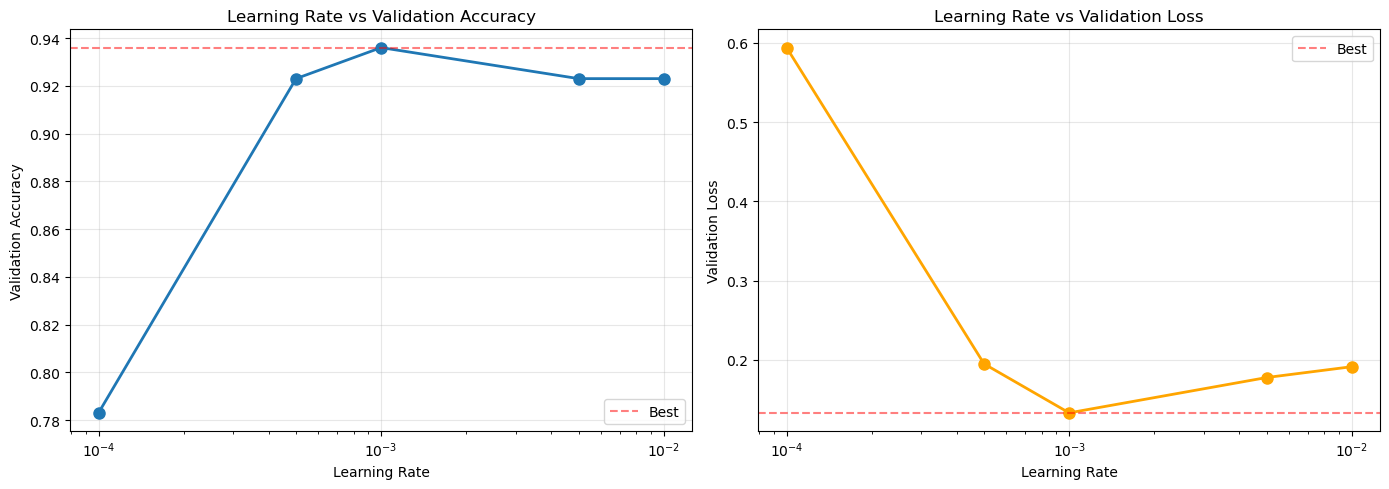


✅ Best Learning Rate: 0.001 with accuracy 0.9360


In [10]:
# Test different learning rates
import tensorflow as tf

learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
lr_results = []

print("Testing different learning rates...")
print("=" * 60)

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    result = train_gru_model(learning_rate=lr, epochs=10)
    lr_results.append({
        'learning_rate': lr,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame for visualization
lr_df = pd.DataFrame(lr_results)
print("\n📊 Learning Rate Results:")
print(lr_df.to_string(index=False))

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(lr_df['learning_rate'], lr_df['val_accuracy'], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Learning Rate vs Validation Accuracy')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=lr_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5, label='Best')
axes[0].legend()

# Loss plot
axes[1].plot(lr_df['learning_rate'], lr_df['val_loss'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Learning Rate vs Validation Loss')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=lr_df['val_loss'].min(), color='r', linestyle='--', alpha=0.5, label='Best')
axes[1].legend()

plt.tight_layout()
plt.show()

best_lr = lr_df.loc[lr_df['val_accuracy'].idxmax(), 'learning_rate']
print(f"\n✅ Best Learning Rate: {best_lr} with accuracy {lr_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 2: Batch Size

Test different batch sizes to find the optimal value.


Testing different batch sizes...
Testing batch size: 16
  Val Accuracy: 0.9375, Val Loss: 0.1385

Testing batch size: 32
  Val Accuracy: 0.9245, Val Loss: 0.1677

Testing batch size: 64
  Val Accuracy: 0.9260, Val Loss: 0.1848

Testing batch size: 128
  Val Accuracy: 0.9230, Val Loss: 0.1935


📊 Batch Size Results:
 batch_size  val_accuracy  val_loss  epochs
         16        0.9375  0.138537      10
         32        0.9245  0.167716       9
         64        0.9260  0.184845      10
        128        0.9230  0.193523      10


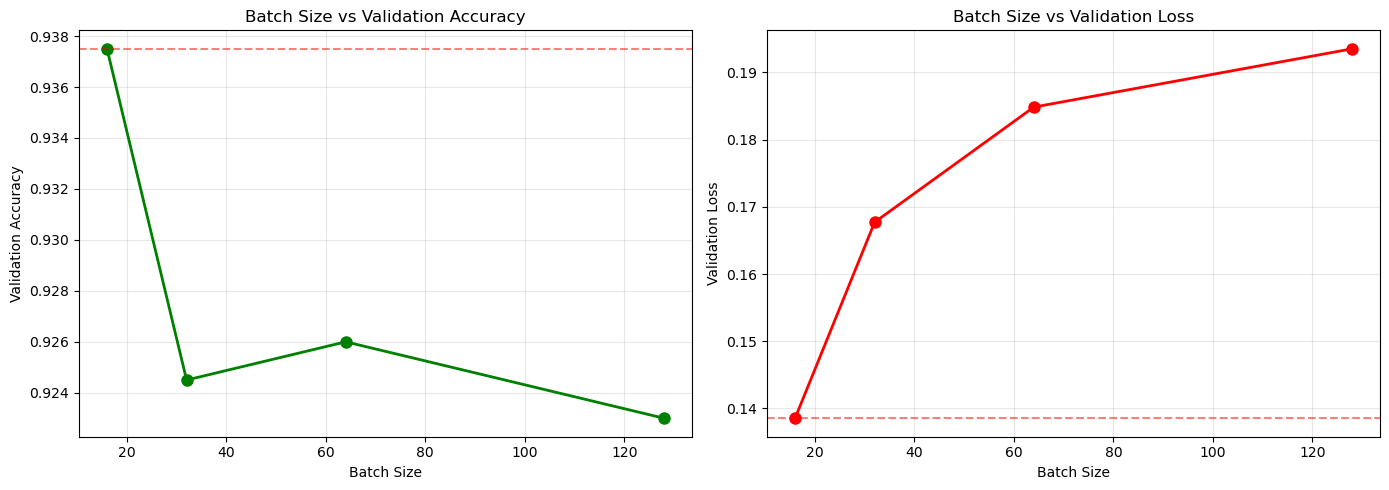


✅ Best Batch Size: 16 with accuracy 0.9375


In [11]:
# Test different batch sizes
batch_sizes = [16, 32, 64, 128]
batch_results = []

print("Testing different batch sizes...")
print("=" * 60)

for bs in batch_sizes:
    print(f"Testing batch size: {bs}")
    result = train_gru_model(batch_size=bs, epochs=10)
    batch_results.append({
        'batch_size': bs,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
batch_df = pd.DataFrame(batch_results)
print("\n📊 Batch Size Results:")
print(batch_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(batch_df['batch_size'], batch_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Batch Size vs Validation Accuracy')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=batch_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5)

axes[1].plot(batch_df['batch_size'], batch_df['val_loss'], 'o-', linewidth=2, markersize=8, color='red')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Batch Size vs Validation Loss')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=batch_df['val_loss'].min(), color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

best_batch = batch_df.loc[batch_df['val_accuracy'].idxmax(), 'batch_size']
print(f"\n✅ Best Batch Size: {best_batch} with accuracy {batch_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 3: GRU Units

Test different numbers of GRU units to find optimal model capacity.


Testing different GRU unit counts...
Testing GRU units: 64
  Val Accuracy: 0.9365, Val Loss: 0.1470

Testing GRU units: 96
  Val Accuracy: 0.9295, Val Loss: 0.1549

Testing GRU units: 128
  Val Accuracy: 0.9255, Val Loss: 0.1703

Testing GRU units: 192
  Val Accuracy: 0.9225, Val Loss: 0.1660

Testing GRU units: 256
  Val Accuracy: 0.9360, Val Loss: 0.1671


📊 GRU Units Results:
 gru_units  val_accuracy  val_loss  epochs
        64        0.9365  0.147029      10
        96        0.9295  0.154934      10
       128        0.9255  0.170263      10
       192        0.9225  0.166032      10
       256        0.9360  0.167138      10


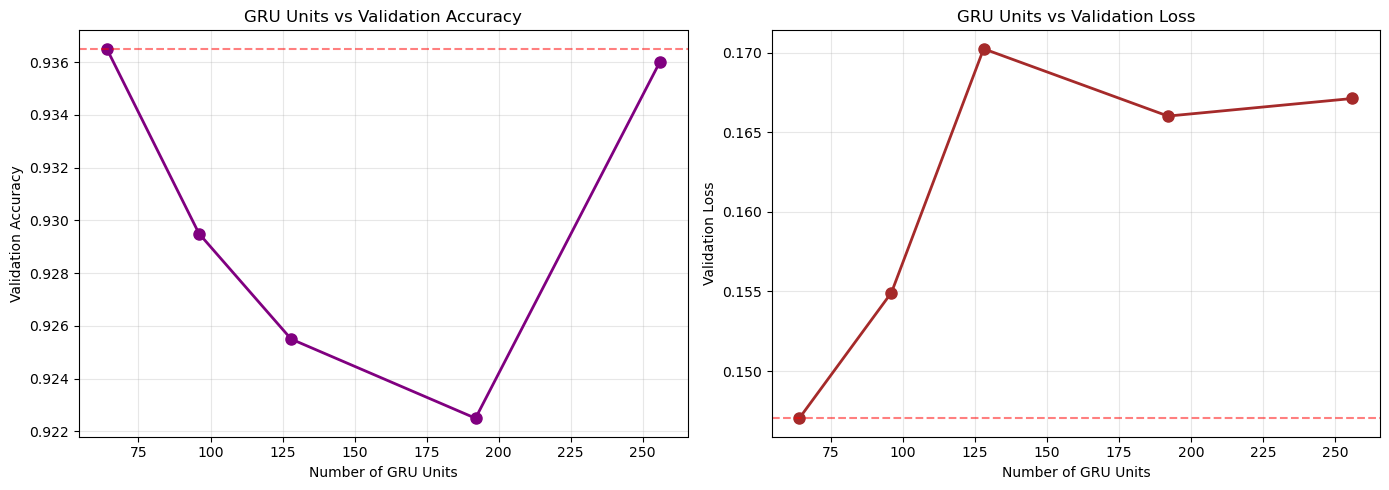


✅ Best GRU Units: 64 with accuracy 0.9365


In [12]:
# Test different numbers of GRU units
gru_units_list = [64, 96, 128, 192, 256]
gru_results = []

print("Testing different GRU unit counts...")
print("=" * 60)

for units in gru_units_list:
    print(f"Testing GRU units: {units}")
    result = train_gru_model(gru_units=units, epochs=10)
    gru_results.append({
        'gru_units': units,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
gru_df = pd.DataFrame(gru_results)
print("\n📊 GRU Units Results:")
print(gru_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(gru_df['gru_units'], gru_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='purple')
axes[0].set_xlabel('Number of GRU Units')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('GRU Units vs Validation Accuracy')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=gru_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5)

axes[1].plot(gru_df['gru_units'], gru_df['val_loss'], 'o-', linewidth=2, markersize=8, color='brown')
axes[1].set_xlabel('Number of GRU Units')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('GRU Units vs Validation Loss')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=gru_df['val_loss'].min(), color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

best_units = gru_df.loc[gru_df['val_accuracy'].idxmax(), 'gru_units']
print(f"\n✅ Best GRU Units: {best_units} with accuracy {gru_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 4: Dropout Rate

Test different dropout rates to find the optimal regularization.


Testing different dropout rates...
Testing dropout rate: 0.2
  Val Accuracy: 0.9205, Val Loss: 0.1762

Testing dropout rate: 0.3
  Val Accuracy: 0.9345, Val Loss: 0.1591

Testing dropout rate: 0.4
  Val Accuracy: 0.9310, Val Loss: 0.1521

Testing dropout rate: 0.5
  Val Accuracy: 0.9285, Val Loss: 0.1538

Testing dropout rate: 0.6
  Val Accuracy: 0.9250, Val Loss: 0.1597


📊 Dropout Rate Results:
 dropout_rate  val_accuracy  val_loss  epochs
          0.2        0.9205  0.176160       7
          0.3        0.9345  0.159070      10
          0.4        0.9310  0.152108      10
          0.5        0.9285  0.153820      10
          0.6        0.9250  0.159715      10


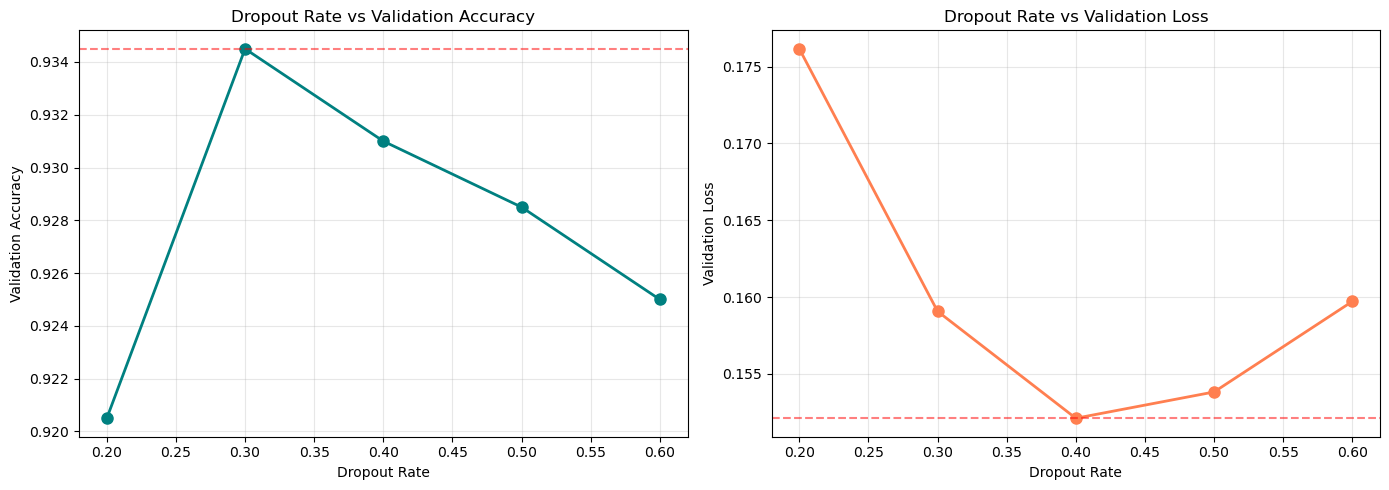


✅ Best Dropout Rate: 0.3 with accuracy 0.9345


In [13]:
# Test different dropout rates
dropout_rates = [0.2, 0.3, 0.4, 0.5, 0.6]
dropout_results = []

print("Testing different dropout rates...")
print("=" * 60)

for dr in dropout_rates:
    print(f"Testing dropout rate: {dr}")
    result = train_gru_model(dropout_rate=dr, epochs=10)
    dropout_results.append({
        'dropout_rate': dr,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
dropout_df = pd.DataFrame(dropout_results)
print("\n📊 Dropout Rate Results:")
print(dropout_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(dropout_df['dropout_rate'], dropout_df['val_accuracy'], 'o-', linewidth=2, markersize=8, color='teal')
axes[0].set_xlabel('Dropout Rate')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Dropout Rate vs Validation Accuracy')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=dropout_df['val_accuracy'].max(), color='r', linestyle='--', alpha=0.5)

axes[1].plot(dropout_df['dropout_rate'], dropout_df['val_loss'], 'o-', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Dropout Rate')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Dropout Rate vs Validation Loss')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=dropout_df['val_loss'].min(), color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

best_dropout = dropout_df.loc[dropout_df['val_accuracy'].idxmax(), 'dropout_rate']
print(f"\n✅ Best Dropout Rate: {best_dropout} with accuracy {dropout_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 5: Optimizer Comparison

Test different optimizers to find the best one.


Testing different optimizers...
Testing optimizer: adam
  Val Accuracy: 0.9165, Val Loss: 0.1932

Testing optimizer: rmsprop
  Val Accuracy: 0.9285, Val Loss: 0.1797

Testing optimizer: sgd
  Val Accuracy: 0.7080, Val Loss: 0.7917


📊 Optimizer Results:
optimizer  val_accuracy  val_loss  epochs
     adam        0.9165  0.193238      10
  rmsprop        0.9285  0.179714      10
      sgd        0.7080  0.791749      10


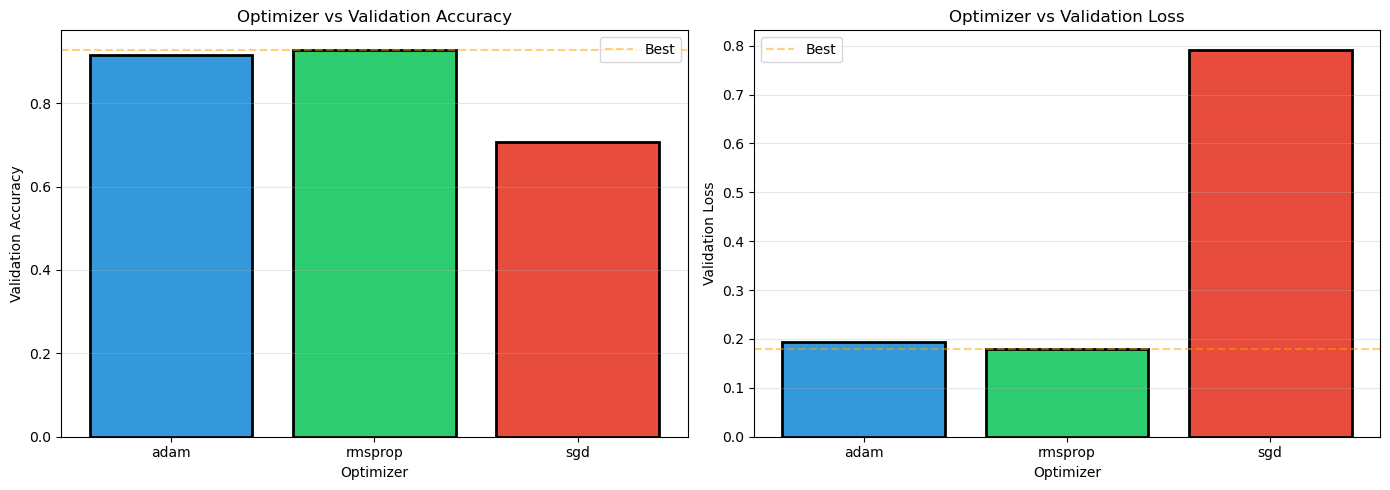


✅ Best Optimizer: rmsprop with accuracy 0.9285


In [14]:
# Test different optimizers
optimizers = ['adam', 'rmsprop', 'sgd']
opt_results = []

print("Testing different optimizers...")
print("=" * 60)

for opt in optimizers:
    print(f"Testing optimizer: {opt}")
    result = train_gru_model(optimizer_name=opt, epochs=10)
    opt_results.append({
        'optimizer': opt,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
opt_df = pd.DataFrame(opt_results)
print("\n📊 Optimizer Results:")
print(opt_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(opt_df['optimizer'], opt_df['val_accuracy'], color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[0].set_xlabel('Optimizer')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Optimizer vs Validation Accuracy')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=opt_df['val_accuracy'].max(), color='orange', linestyle='--', alpha=0.5, label='Best')
axes[0].legend()

axes[1].bar(opt_df['optimizer'], opt_df['val_loss'], color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[1].set_xlabel('Optimizer')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Optimizer vs Validation Loss')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=opt_df['val_loss'].min(), color='orange', linestyle='--', alpha=0.5, label='Best')
axes[1].legend()

plt.tight_layout()
plt.show()

best_opt = opt_df.loc[opt_df['val_accuracy'].idxmax(), 'optimizer']
print(f"\n✅ Best Optimizer: {best_opt} with accuracy {opt_df['val_accuracy'].max():.4f}")


### 🔍 Experiment 6: Embedding Trainability

Compare frozen vs fine-tuned Word2Vec embeddings.


Testing embedding trainability...
Testing: Frozen embeddings
  Val Accuracy: 0.9285, Val Loss: 0.1875

Testing: Fine-tuned embeddings
  Val Accuracy: 0.9235, Val Loss: 0.2057


📊 Embedding Trainability Results:
configuration  val_accuracy  val_loss  epochs
       Frozen        0.9285  0.187454      10
   Fine-tuned        0.9235  0.205667       5


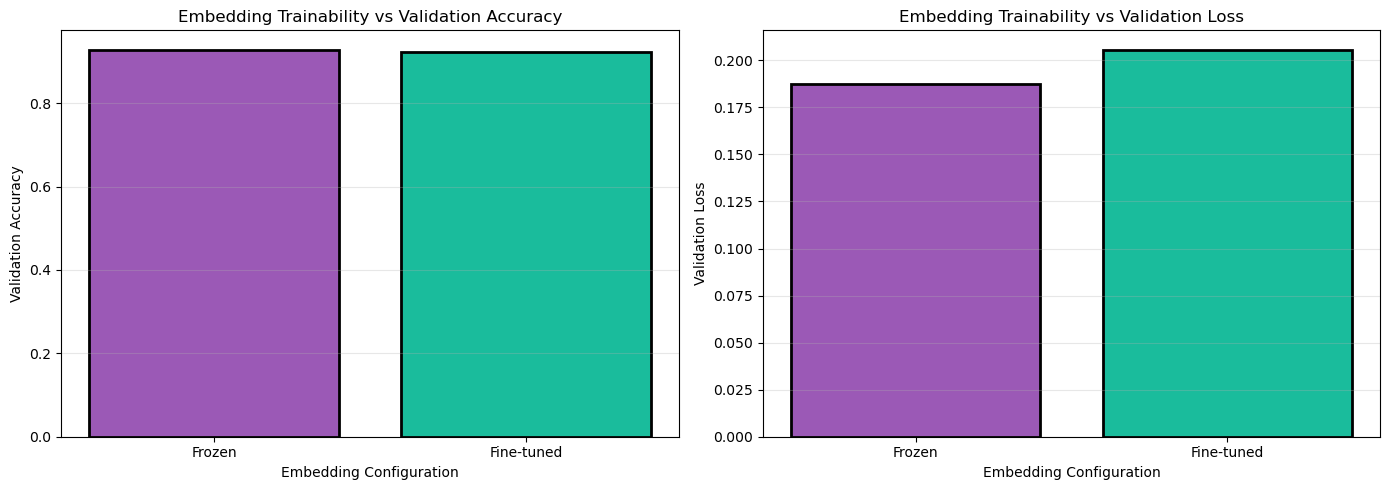


✅ Best Configuration: Frozen embeddings with accuracy 0.9285


In [15]:
# Test embedding trainability
emb_configs = [False, True]
emb_labels = ['Frozen', 'Fine-tuned']
emb_results = []

print("Testing embedding trainability...")
print("=" * 60)

for trainable, label in zip(emb_configs, emb_labels):
    print(f"Testing: {label} embeddings")
    result = train_gru_model(embedding_trainable=trainable, epochs=10)
    emb_results.append({
        'configuration': label,
        'trainable': trainable,
        'val_accuracy': result['val_accuracy'],
        'val_loss': result['val_loss'],
        'epochs': result['best_epoch']
    })
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}, Val Loss: {result['val_loss']:.4f}\n")

# Convert to DataFrame
emb_df = pd.DataFrame(emb_results)
print("\n📊 Embedding Trainability Results:")
print(emb_df[['configuration', 'val_accuracy', 'val_loss', 'epochs']].to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(emb_df['configuration'], emb_df['val_accuracy'], color=['#9b59b6', '#1abc9c'], edgecolor='black', linewidth=2)
axes[0].set_xlabel('Embedding Configuration')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Embedding Trainability vs Validation Accuracy')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(emb_df['configuration'], emb_df['val_loss'], color=['#9b59b6', '#1abc9c'], edgecolor='black', linewidth=2)
axes[1].set_xlabel('Embedding Configuration')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Embedding Trainability vs Validation Loss')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

best_emb = emb_df.loc[emb_df['val_accuracy'].idxmax(), 'configuration']
print(f"\n✅ Best Configuration: {best_emb} embeddings with accuracy {emb_df['val_accuracy'].max():.4f}")


### 📊 Comprehensive Hyperparameter Tuning Summary

Let's compare all the best configurations from each experiment.



🏆 HYPERPARAMETER TUNING RESULTS SUMMARY
Hyperparameter Best Value  Val Accuracy  Val Loss
 Learning Rate      0.001        0.9360  0.133279
    Batch Size         16        0.9375  0.138537
     GRU Units         64        0.9365  0.147029
  Dropout Rate        0.3        0.9345  0.159070
     Optimizer    rmsprop        0.9285  0.179714
Embedding Mode     Frozen        0.9285  0.187454


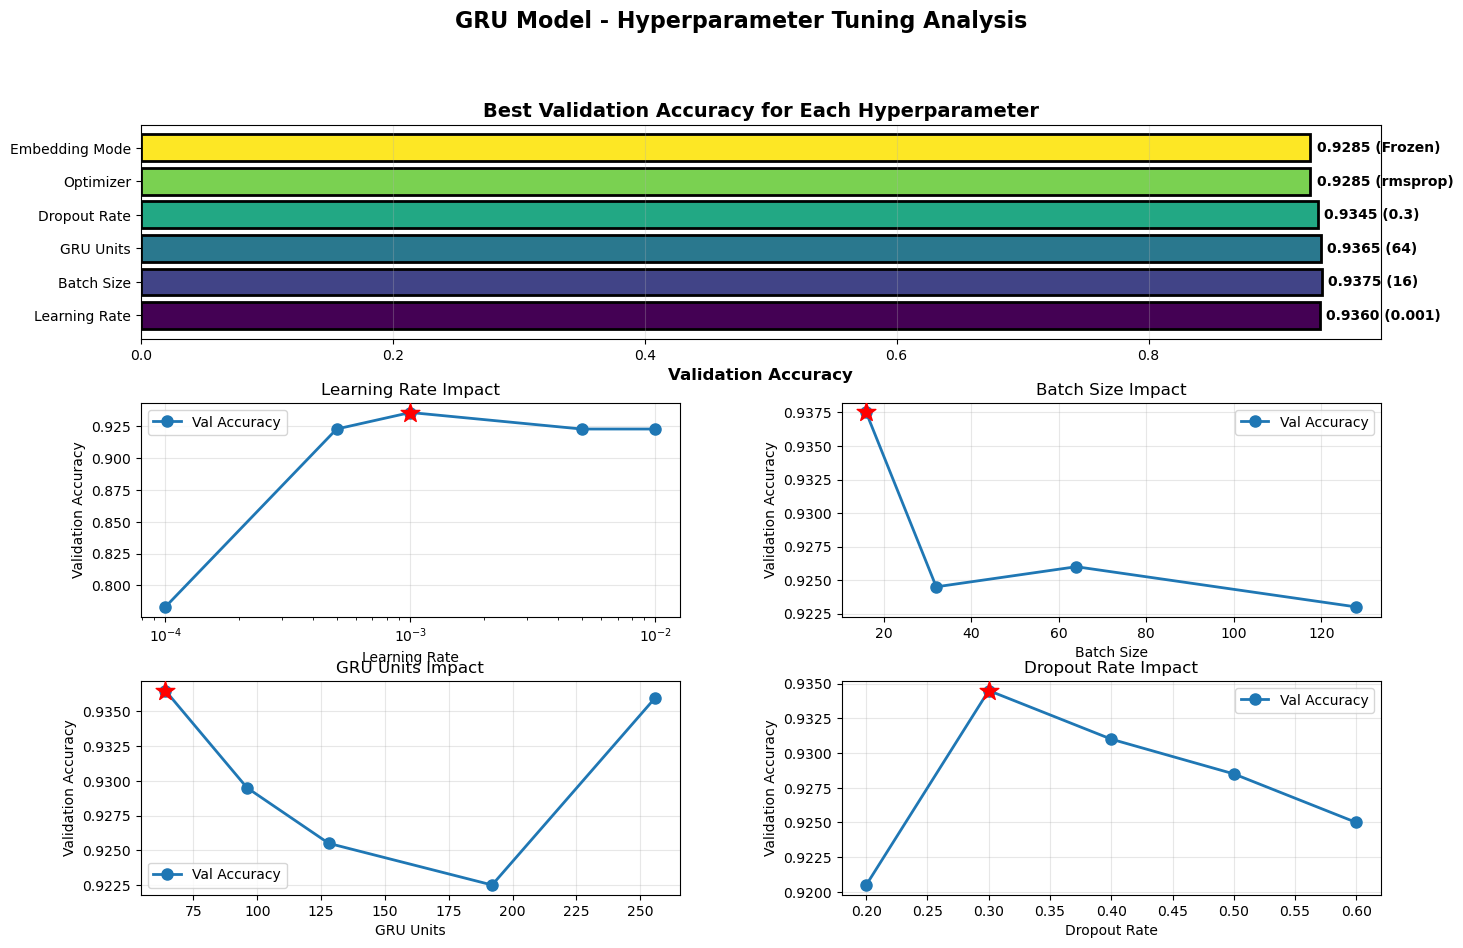


💡 RECOMMENDATIONS FOR OPTIMAL GRU MODEL
Learning Rate:       0.001
Batch Size:          16
GRU Units:           64
Dropout Rate:        0.3
Optimizer:           rmsprop
Embedding Mode:      Frozen

🎯 Expected Validation Accuracy: 0.9375
📉 Expected Validation Loss:     0.1333


In [16]:
# Create comprehensive summary
summary_data = []

# Learning Rate
best_lr_row = lr_df.loc[lr_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Learning Rate',
    'Best Value': f"{best_lr_row['learning_rate']}",
    'Val Accuracy': best_lr_row['val_accuracy'],
    'Val Loss': best_lr_row['val_loss']
})

# Batch Size
best_batch_row = batch_df.loc[batch_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Batch Size',
    'Best Value': f"{int(best_batch_row['batch_size'])}",
    'Val Accuracy': best_batch_row['val_accuracy'],
    'Val Loss': best_batch_row['val_loss']
})

# GRU Units
best_gru_row = gru_df.loc[gru_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'GRU Units',
    'Best Value': f"{int(best_gru_row['gru_units'])}",
    'Val Accuracy': best_gru_row['val_accuracy'],
    'Val Loss': best_gru_row['val_loss']
})

# Dropout Rate
best_dropout_row = dropout_df.loc[dropout_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Dropout Rate',
    'Best Value': f"{best_dropout_row['dropout_rate']}",
    'Val Accuracy': best_dropout_row['val_accuracy'],
    'Val Loss': best_dropout_row['val_loss']
})

# Optimizer
best_opt_row = opt_df.loc[opt_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Optimizer',
    'Best Value': best_opt_row['optimizer'],
    'Val Accuracy': best_opt_row['val_accuracy'],
    'Val Loss': best_opt_row['val_loss']
})

# Embedding Trainability
best_emb_row = emb_df.loc[emb_df['val_accuracy'].idxmax()]
summary_data.append({
    'Hyperparameter': 'Embedding Mode',
    'Best Value': best_emb_row['configuration'],
    'Val Accuracy': best_emb_row['val_accuracy'],
    'Val Loss': best_emb_row['val_loss']
})

summary_df = pd.DataFrame(summary_data)

print("\n" + "=" * 80)
print("🏆 HYPERPARAMETER TUNING RESULTS SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

# Visualize all best configurations
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Best Accuracy for each hyperparameter
ax1 = fig.add_subplot(gs[0, :])
colors = plt.cm.viridis(np.linspace(0, 1, len(summary_df)))
bars = ax1.barh(summary_df['Hyperparameter'], summary_df['Val Accuracy'], color=colors, edgecolor='black', linewidth=2)
ax1.set_xlabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Best Validation Accuracy for Each Hyperparameter', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, val, best_val) in enumerate(zip(bars, summary_df['Val Accuracy'], summary_df['Best Value'])):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f} ({best_val})', va='center', fontweight='bold')

# Plot 2-7: Individual experiment results
experiments = [
    (lr_df, 'learning_rate', 'Learning Rate', 'log'),
    (batch_df, 'batch_size', 'Batch Size', 'linear'),
    (gru_df, 'gru_units', 'GRU Units', 'linear'),
    (dropout_df, 'dropout_rate', 'Dropout Rate', 'linear'),
]

for idx, (df, x_col, title, scale) in enumerate(experiments):
    ax = fig.add_subplot(gs[1 + idx // 2, idx % 2])
    ax.plot(df[x_col], df['val_accuracy'], 'o-', linewidth=2, markersize=8, label='Val Accuracy')
    ax.set_xlabel(title)
    ax.set_ylabel('Validation Accuracy')
    ax.set_title(f'{title} Impact')
    if scale == 'log':
        ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend()
    # Highlight best
    best_idx = df['val_accuracy'].idxmax()
    ax.scatter(df.loc[best_idx, x_col], df.loc[best_idx, 'val_accuracy'], 
               color='red', s=200, marker='*', zorder=5, label='Best')

plt.suptitle('GRU Model - Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print recommendations
print("\n" + "=" * 80)
print("💡 RECOMMENDATIONS FOR OPTIMAL GRU MODEL")
print("=" * 80)
print(f"Learning Rate:       {summary_df.loc[0, 'Best Value']}")
print(f"Batch Size:          {summary_df.loc[1, 'Best Value']}")
print(f"GRU Units:           {summary_df.loc[2, 'Best Value']}")
print(f"Dropout Rate:        {summary_df.loc[3, 'Best Value']}")
print(f"Optimizer:           {summary_df.loc[4, 'Best Value']}")
print(f"Embedding Mode:      {summary_df.loc[5, 'Best Value']}")
print("=" * 80)
print(f"\n🎯 Expected Validation Accuracy: {summary_df['Val Accuracy'].max():.4f}")
print(f"📉 Expected Validation Loss:     {summary_df['Val Loss'].min():.4f}")


## 🏆 Extract Best Hyperparameters

⚠️ **IMPORTANT:** Before running this cell, make sure you have run **ALL** the hyperparameter experiment cells above:
- Experiment 1: Learning Rate
- Experiment 2: Batch Size
- Experiment 3: GRU Units
- Experiment 4: Dropout Rate
- Experiment 5: Optimizer Comparison
- Experiment 6: Embedding Trainability

This cell analyzes results from all experiments to identify the best configuration.


In [ ]:
# Analyze all experimental results to find best hyperparameters
print("📊 Summary of Best Hyperparameters from Experiments:")
print("=" * 60)

# Check if all required DataFrames exist
required_dfs = ['lr_df', 'bs_df', 'units_df', 'dropout_df', 'opt_df', 'emb_df']
missing_dfs = [df for df in required_dfs if df not in globals()]

if missing_dfs:
    print("\n❌ ERROR: Some experiment results are missing!")
    print("Please run ALL hyperparameter experiment cells first:")
    print("   - Experiment 1: Learning Rate")
    print("   - Experiment 2: Batch Size")
    print("   - Experiment 3: GRU Units")
    print("   - Experiment 4: Dropout Rate")
    print("   - Experiment 5: Optimizer Comparison")
    print("   - Experiment 6: Embedding Trainability")
    print(f"\nMissing DataFrames: {', '.join(missing_dfs)}")
    raise RuntimeError("Run all experiment cells before extracting best hyperparameters")

# Best learning rate
best_lr = lr_df.loc[lr_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Learning Rate: {best_lr['learning_rate']}")
print(f"   Val Accuracy: {best_lr['val_accuracy']:.4f}")

# Best batch size
best_bs = bs_df.loc[bs_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Batch Size: {best_bs['batch_size']:.0f}")
print(f"   Val Accuracy: {best_bs['val_accuracy']:.4f}")

# Best GRU units
best_units = units_df.loc[units_df['val_accuracy'].idxmax()]
print(f"\n✅ Best GRU Units: {best_units['gru_units']:.0f}")
print(f"   Val Accuracy: {best_units['val_accuracy']:.4f}")

# Best dropout rate
best_dropout = dropout_df.loc[dropout_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Dropout Rate: {best_dropout['dropout_rate']}")
print(f"   Val Accuracy: {best_dropout['val_accuracy']:.4f}")

# Best optimizer
best_opt = opt_df.loc[opt_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Optimizer: {best_opt['optimizer']}")
print(f"   Val Accuracy: {best_opt['val_accuracy']:.4f}")

# Best embedding trainability
best_emb = emb_df.loc[emb_df['val_accuracy'].idxmax()]
print(f"\n✅ Best Embedding Trainability: {best_emb['embedding_trainable']}")
print(f"   Val Accuracy: {best_emb['val_accuracy']:.4f}")

# Store best hyperparameters
best_hyperparameters = {
    'learning_rate': best_lr['learning_rate'],
    'batch_size': int(best_bs['batch_size']),
    'gru_units': int(best_units['gru_units']),
    'dropout_rate': best_dropout['dropout_rate'],
    'optimizer': best_opt['optimizer'],
    'embedding_trainable': best_emb['embedding_trainable']
}

print("\n" + "=" * 60)
print("🎯 Final Best Configuration:")
print("=" * 60)
for key, value in best_hyperparameters.items():
    print(f"  {key}: {value}")
print("=" * 60)


📊 Summary of Best Hyperparameters from Experiments:

✅ Best Learning Rate: 0.001
   Val Accuracy: 0.9360


NameError: name 'bs_df' is not defined

## 🏗️ Build Final GRU Model with Best Hyperparameters

Now we build the final model using the best hyperparameters identified from experiments.


In [ ]:
# Build final model with best hyperparameters
final_model = Sequential()

# Embedding layer
final_model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=best_hyperparameters['embedding_trainable']
))

# Bidirectional GRU layer with best units
final_model.add(Bidirectional(GRU(best_hyperparameters['gru_units'])))

# Batch normalization
final_model.add(BatchNormalization())

# Dropout with best rate
final_model.add(Dropout(best_hyperparameters['dropout_rate']))

# Dense layer
final_model.add(Dense(64, activation='relu'))

# Dropout
final_model.add(Dropout(best_hyperparameters['dropout_rate']))

# Output layer
final_model.add(Dense(6, activation='softmax'))

# Compile with best optimizer and learning rate
if best_hyperparameters['optimizer'] == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate'])
elif best_hyperparameters['optimizer'] == 'rmsprop':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_hyperparameters['learning_rate'])
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=best_hyperparameters['learning_rate'], momentum=0.9)

final_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Build the model to initialize all layers
final_model.build(input_shape=(None, maxlen))

print("\n🎯 Final GRU Model with Best Hyperparameters")
print(f"Learning Rate: {best_hyperparameters['learning_rate']}")
print(f"Batch Size: {best_hyperparameters['batch_size']}")
print(f"GRU Units: {best_hyperparameters['gru_units']}")
print(f"Dropout Rate: {best_hyperparameters['dropout_rate']}")
print(f"Optimizer: {best_hyperparameters['optimizer']}")
print(f"Embedding Trainable: {best_hyperparameters['embedding_trainable']}")
print()
final_model.summary()


## 🚀 Train Final Model

Train the final model with the best hyperparameters.


In [ ]:
# Train the final model
print("🚀 Training final model with best hyperparameters...")
print("=" * 60)

# Analyze epochs from experiments to set reasonable max_epochs
avg_epochs = np.mean([
    lr_df['epochs'].mean(),
    bs_df['epochs'].mean(),
    units_df['epochs'].mean(),
    dropout_df['epochs'].mean(),
    opt_df['epochs'].mean(),
    emb_df['epochs'].mean()
])
print(f"Average epochs from experiments: {avg_epochs:.1f}")
print(f"Setting max_epochs=30 with early stopping (patience=5)")
print(f"This prevents overfitting while allowing enough training time.\n")

# Early Stopping callback:
# - Monitors validation loss (more stable than accuracy)
# - patience=5: stops if no improvement for 5 epochs
# - restore_best_weights=True: uses weights from best epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = final_model.fit(
    X_train_padded, y_train,
    epochs=30,  # Max epochs (will likely stop earlier via EarlyStopping)
    batch_size=best_hyperparameters['batch_size'],
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stop],
    verbose=1
)

actual_epochs = len(history.history['loss'])
print(f"\n✅ Training completed!")
print(f"Trained for {actual_epochs} epochs (stopped early to prevent overfitting)")


## 📊 Visualize Training Progress


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 Final Training Metrics:")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Loss: {final_val_loss:.4f}")


## 📈 Evaluate Final Model Performance


In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = final_model.evaluate(X_val_padded, y_val, verbose=0)
print(f"\n📊 Final Model Performance:")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Validation Accuracy: {val_accuracy:.4f}")

# Generate predictions
y_pred = final_model.predict(X_val_padded, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)


## 🎯 Confusion Matrix


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'],
            yticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
plt.title('Confusion Matrix - Final GRU Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## 📝 Classification Report


In [ ]:
# Generate classification report
emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
report = classification_report(y_val, y_pred_classes, target_names=emotion_labels)
print("\n📝 Classification Report:")
print("=" * 60)
print(report)


## 💾 Save Final Model and Tokenizer

Save the final model (trained with best hyperparameters), tokenizer, and metadata.


In [ ]:
import os

# Create output directory
output_dir = './data/gru'
os.makedirs(output_dir, exist_ok=True)

# Save the final model
model_path = os.path.join(output_dir, 'gru_model.keras')
final_model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# Save tokenizer
tokenizer_path = os.path.join(output_dir, 'gru_tokenizer.pkl')
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✅ Tokenizer saved to: {tokenizer_path}")

# Save metadata including best hyperparameters
metadata = {
    'maxlen': maxlen,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'best_hyperparameters': best_hyperparameters,
    'val_accuracy': val_accuracy,
    'val_loss': val_loss,
    'emotion_labels': emotion_labels
}

metadata_path = os.path.join(output_dir, 'gru_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✅ Metadata saved to: {metadata_path}")

print("\n" + "=" * 60)
print("✅ All files saved successfully!")
print("=" * 60)
print(f"\nFinal Model Performance:")
print(f"  Validation Accuracy: {val_accuracy:.4f}")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"\nBest Hyperparameters Used:")
for key, value in best_hyperparameters.items():
    print(f"  {key}: {value}")
